# Spatial correlation

$$r = \frac{\sum[(F^\text{true} - \langle F^\text{true}\rangle) (F^\text{param} - \langle F^\text{param}\rangle)]}{\sqrt{\sum[(F^\text{true} - \langle F^\text{true}\rangle)^2]}\sqrt{\sum[(F^\text{param} - \langle F^\text{param}\rangle)^2]}}$$

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46669")
client

Client Scheduler: tcp://127.0.0.1:46669 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 40 Memory: 168.99 GB


In [2]:
import numpy as np
import xarray as xr
import gsw
import time
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import dask_image.ndfilters as dsfilt
import scipy.sparse as spar
import dask.array as dsar
# from xhistogram.xarray import histogram as xhist
# import xrft
import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib.lines import Line2D
%matplotlib inline

In [3]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [4]:
dnf = 2160

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50
sstart = 23
send = 49
nremap = 50
dnf = 2160
nchk = 20
nhskp = 3
nbskp = 2
nremap = 80
nfile = 73

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [5]:
# ny, nx, nb = (3,3,1)
# def _filt(da, nker=np.ones((ny,nx,nb))):
#     return xr.DataArray(dsfilt.median_filter(da.data, footprint=nker), 
#                         dims=da.dims, coords=da.coords)

def _filt(da, area=None, dim=['YC','XC'], nker=15, cutoff=11):
    
    if area is not None:
        win_2D = (da * area).window
    else:
        win_2D = da.window
    
    win_2D.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
    bw = win_2D.boundary_weights(drop_dims=[])
    da_LS = win_2D.convolve(weights=bw)
    
    if area is not None:
        area_win = area.window
        area_win.set(window='hanning', cutoff=cutoff, dim=dim, n=[nker,nker])
        bw = area_win.boundary_weights(drop_dims=[])
        da_LS *= area_win.convolve(weights=bw)**-1
    
    return da_LS

In [47]:
years = np.arange(2008,2013,dtype=int)
ntimes = np.arange(7886160,8672400+dnf,dnf).reshape(len(years),nfile)
dd = 3
yystart = 0
ntimes[yystart,dd]

7892640

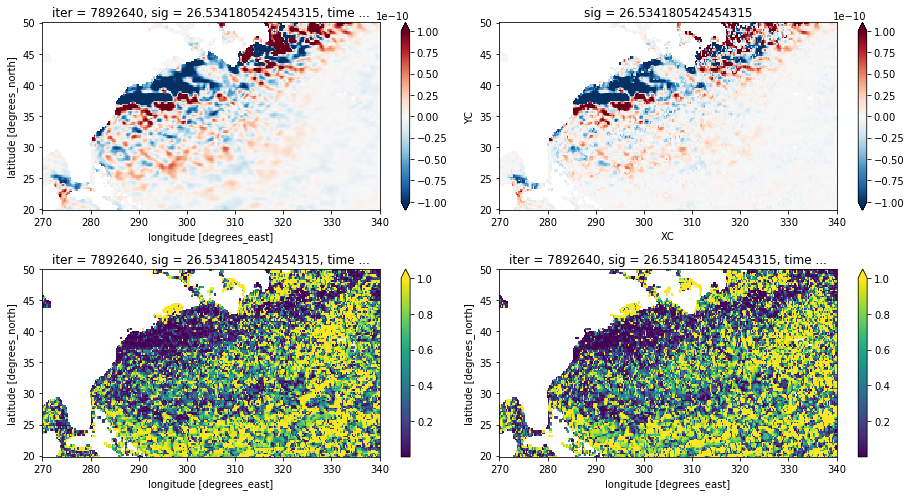

<xarray.Dataset>
Dimensions:  (XC: 272, YC: 121, sig: 13)
Coordinates:
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 3630.6226 3514.8845 4358.017
  * XC       (XC) float32 270.00348 270.26166 270.51984 ... 339.71088 339.96906
  * YC       (YC) float64 19.92 20.17 20.42 20.67 ... 49.17 49.42 49.67 49.92
    iter     int64 7892640
    maskInC  (YC, XC) bool False False False False False ... True True True True
    rA       (YC, XC) float32 83341496.0 83341496.0 ... 57077510.0 57077510.0
  * sig      (sig) float64 26.23 26.53 26.81 27.06 ... 28.12 28.24 28.34 28.43
    time     timedelta64[ns] 18270 days
Data variables:
    exP      (YC, XC, sig) float64 nan nan nan nan ... 0.2699 0.7986 0.004212
    eyP      (YC, XC, sig) float64 nan nan nan nan ... 0.1715 0.8539 0.2904
    exT      (YC, XC, sig) float64 nan nan nan nan ... 0.08611 0.1242 0.02075
    eyT      (YC, XC, sig) float64 nan nan nan nan ... 0.4437 0.1404 1.494
    exS      (YC, XC, sig) float64 nan nan nan nan ... 0.07306 0

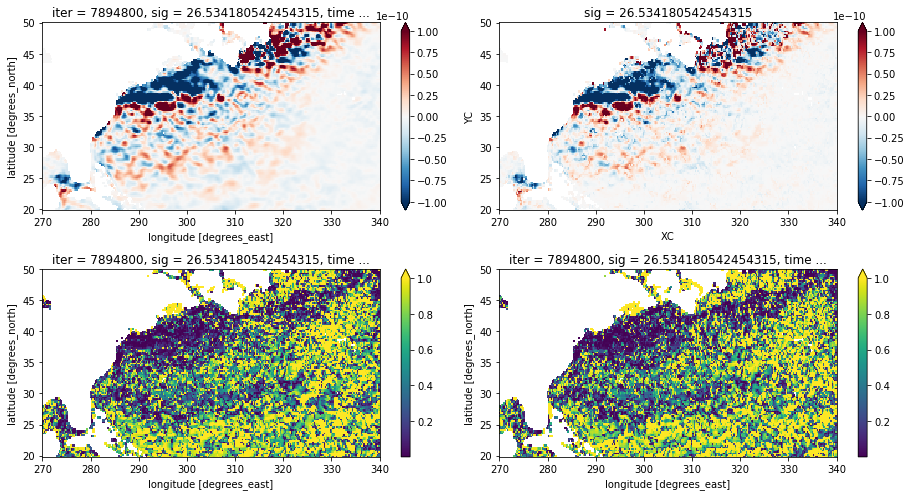

Lapse time: 302.71653485298157
7894800


In [48]:
yy = yystart
xlim = [270,340]

for year in years[yystart:1]:
    if year == years[yystart]:
        mtimes = ntimes[yy,dd:5]
        ystart = yNstart
    else:
        mtimes = ntimes[yy]
        ystart = yNstart
    for itime in mtimes:
        
        K = xr.open_dataset(op.join(ddir,
                        '5Dave/run%4d/Kappas_isig%2d-%2d_nhskip3_nbskip2_%010d.nc' 
                                    % (year,sstart,send,itime))
                           ).K.sel(XC=slice(xlim[0],xlim[1]))
        ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                      % (0,year)), 
                             grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                             iters=itime,
                             prefix=['diag_ocnTave'], delta_t=2e2,
                            ).sel(YC=slice(yNstart,yend+12**-1), 
                                  YG=slice(yNstart,yend+12**-1)
                                 ).chunk({'XC':xchunk,'XG':xchunk,
                                          'YC':ychunk,'YG':ychunk})
#         dsz = xr.open_dataset(op.join(ddir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
#                                       % (year,nremap,itime)),
#                               chunks={'nmemb':1}
#                              ).isel(sig=slice(sstart,send),
#                                     sigp1=slice(sstart,send+1)
#                                    ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1),
#                                          YG=slice(yNstart+10-12**-1,yend+2*12**-1))
#         dsmn = xr.open_dataset(op.join(ddir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
#                                        % (year,nremap,itime)),
#                                chunks={'nmemb':1}
#                               ).isel(sig=slice(sstart,send),
#                                      sigp1=slice(sstart,send+1)
#                                     ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1),
#                                           YG=slice(yNstart+10-12**-1,yend+2*12**-1))
#         dsdiv = xr.open_dataset(op.join(ddir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
#                                         % (year,nremap,itime)),
#                                ).isel(sig=slice(sstart,send),
#                                       sigp1=slice(sstart,send+1)
#                                      ).sel(YC=slice(yNstart+10-12**-1,yend+2*12**-1),
#                                            YG=slice(yNstart+10-12**-1,yend+2*12**-1))
        dsmn = xr.open_zarr(op.join(ddir,'5Dave/run%4d/Dyns/%010d' % (year,itime))
                           ).isel(sig=slice(sstart,send),
                                  sigp1=slice(sstart,send+1)
                                 ).sel(YC=slice(yNstart,yend+12**-1),
                                       YG=slice(yNstart,yend+12**-1))
        dsz = xr.open_zarr(op.join(ddir,'5Dave/run%4d/Zs/%010d' % (year,itime))
                          ).isel(sig=slice(sstart,send),
                                 sigp1=slice(sstart,send+1)
                                ).sel(YC=slice(yNstart,yend+12**-1),
                                      YG=slice(yNstart,yend+12**-1))
        dsep = xr.open_zarr(op.join(ddir,'5Dave/run%4d/E-P/%010d' % (year,itime))
                           ).isel(sig=slice(sstart,send),
                                  sigp1=slice(sstart,send+1)
                                 ).sel(YC=slice(yNstart,yend+12**-1),
                                       YG=slice(yNstart,yend+12**-1))
    
        if itime == mtimes[0]:
            grid = Grid(dsz, periodic=['X'], 
                        coords={'Z':{'center':'sig','outer':'sigp1'},
                               'Y':{'center':'YC','left':'YG'},
                               'X':{'center':'XC','left':'XG'}}
                       )
        buoybp1 = -grav * dsz.sigp1 * rhoConst**-1
        sigma = dsz.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmay = dsz.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmax = dsz.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

        sigmab = (dsz.dzetaF.mean('nmemb',skipna=True) 
                  * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                 )
        sigmaxb = (dsz.dzetaFx.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )
        sigmayb = (dsz.dzetaFy.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )
        
##########################
        vhat = (dsmn.vdz.mean('nmemb',skipna=True) 
                * dsz.dzetaFy.mean('nmemb',skipna=True)**-1)
        uhat = (dsmn.udz.mean('nmemb',skipna=True) 
                * dsz.dzetaFx.mean('nmemb',skipna=True)**-1)
        vort = (grid.diff(vhat*ds.dyC,'X') 
                - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
               ) * ds.rAz**-1
        fC = xr.apply_ufunc(gsw.f, dsz.YC)
        Pi = (fC + grid.interp(grid.interp(vort,'Y',boundary='fill'),
                               'X')
             ) * sigmab**-1
        Pi_sm = _filt(Pi.chunk({'YC':ychunk,'XC':xchunk}))
        Pism_x = grid.interp(grid.diff(Pi_sm,'X') * ds.dxC**-1,'X')
        Pism_y = grid.interp(grid.diff(Pi_sm,'Y',boundary='fill') * ds.dyC**-1,
                             'Y',boundary='fill')
        FxP = -(K[:,:,:,0,0] * Pism_x
                + K[:,:,:,1,0] * Pism_y
               ).sel(YC=slice(yNstart+10-12**-1,yend+12**-1))
        FyP = -(K[:,:,:,0,1] * Pism_x
                + K[:,:,:,1,1] * Pism_y
               ).sel(YC=slice(yNstart+10-12**-1,yend+12**-1))
####
        that = (dsmn.tdz.mean('nmemb',skipna=True) 
                * dsz.dzetaF.mean('nmemb',skipna=True)**-1)
        shat = (dsmn.sdz.mean('nmemb',skipna=True) 
                * dsz.dzetaF.mean('nmemb',skipna=True)**-1)
        that_sm = _filt(that.chunk({'YC':ychunk,'XC':xchunk}))
        shat_sm = _filt(shat.chunk({'YC':ychunk,'XC':xchunk}))
        thatsm_x = grid.interp(grid.diff(that_sm,'X') * ds.dxC**-1,'X')
        thatsm_y = grid.interp(grid.diff(that_sm,'Y',boundary='fill') * ds.dyC**-1,
                               'Y',boundary='fill')
        shatsm_x = grid.interp(grid.diff(shat_sm,'X') * ds.dxC**-1,'X')
        shatsm_y = grid.interp(grid.diff(shat_sm,'Y',boundary='fill') * ds.dyC**-1,
                               'Y',boundary='fill')
        FxT = -(K[:,:,:,0,0] * thatsm_x
                + K[:,:,:,1,0] * thatsm_y
               ).sel(YC=slice(yNstart+10-12**-1,yend+12**-1))
        FyT = -(K[:,:,:,0,1] * thatsm_x
                + K[:,:,:,1,1] * thatsm_y
               ).sel(YC=slice(yNstart+10-12**-1,yend+12**-1))
        FxS = -(K[:,:,:,0,0] * shatsm_x
                + K[:,:,:,1,0] * shatsm_y
               ).sel(YC=slice(yNstart+10-12**-1,yend+12**-1))
        FyS = -(K[:,:,:,0,1] * shatsm_x
                + K[:,:,:,1,1] * shatsm_y
               ).sel(YC=slice(yNstart+10-12**-1,yend+12**-1))

##########################
        e20_b = dsep.e20_0b + dsep.e20_1b
        e21_b = dsep.e21_0b + dsep.e21_1b
        Eu = dsep.e00x + dsep.e10y + e20_b
        Ev = dsep.e01x + dsep.e11y + e21_b
        Fhashx = (sigmab**-1 * Ev)
        Fhashy = (-sigmab**-1 * Eu)
        upPp = _filt(Fhashx.chunk({'YC':ychunk,'XC':xchunk}), 
                     dim=['YC','XC']
                    ).sel(sig=FxP.sig.data,YC=FxP.YC.data,XC=FxP.XC.data)
        vpPp = _filt(Fhashy.chunk({'YC':ychunk,'XC':xchunk}), 
                     dim=['YC','XC']
                    ).sel(sig=FyP.sig.data,YC=FyP.YC.data,XC=FyP.XC.data)

        vpp = dsmn.vdz*dsz.dzetaFy**-1 - vhat
        upp = dsmn.udz*dsz.dzetaFx**-1 - uhat
        tpp = dsmn.tdz*dsz.dzetaF**-1 - that
        spp = dsmn.sdz*dsz.dzetaF**-1 - shat
        upptpphat = (upp*grid.interp(tpp,'X')
                     * sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
        vpptpphat = (vpp*grid.interp(tpp,'Y',boundary='fill')
                     * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
        uppspphat = (upp*grid.interp(spp,'X')
                     * sigmax).mean('nmemb',skipna=True) * sigmaxb**-1
        vppspphat = (vpp*grid.interp(spp,'Y',boundary='fill')
                     * sigmay).mean('nmemb',skipna=True) * sigmayb**-1
        uptphat_sm = _filt(upptpphat.chunk({'YC':ychunk,'XG':xchunk}), 
                           dim=['YC','XG'])
        vptphat_sm = _filt(vpptpphat.chunk({'YG':ychunk,'XC':xchunk}), 
                           dim=['YG','XC'])
        upsphat_sm = _filt(uppspphat.chunk({'YC':ychunk,'XG':xchunk}), 
                           dim=['YC','XG'])
        vpsphat_sm = _filt(vppspphat.chunk({'YG':ychunk,'XC':xchunk}), 
                           dim=['YG','XC'])
        upTp = grid.interp(uptphat_sm,'X').sel(sig=FxT.sig.data,YC=FxT.YC.data,
                                               XC=FxT.XC.data)
        vpTp = grid.interp(vptphat_sm,'Y',boundary='fill'
                          ).sel(sig=FyT.sig.data,YC=FyT.YC.data,XC=FyT.XC.data)
        upSp = grid.interp(upsphat_sm,'X').sel(sig=FxS.sig.data,YC=FxS.YC.data,
                                               XC=FxS.XC.data)
        vpSp = grid.interp(vpsphat_sm,'Y',boundary='fill'
                          ).sel(sig=FyS.sig.data,YC=FyS.YC.data,XC=FyS.XC.data)

##########################
        start = time.time()
        ename = op.join(ddir,'5Dave/run%4d/Error_isig%2d-%2d_%010d.nc' 
                        % (year,sstart,send,itime))
        exP = (np.abs(upPp - FxP) * np.abs(upPp)**-1).compute()
        eyP = (np.abs(vpPp - FyP) * np.abs(vpPp)**-1).compute()
        exT = (np.abs(upTp - FxT) * np.abs(upTp)**-1).compute()
        eyT = (np.abs(vpTp - FyT) * np.abs(vpTp)**-1).compute()
        exS = (np.abs(upSp - FxS) * np.abs(upSp)**-1).compute()
        eyS = (np.abs(vpSp - FyS) * np.abs(vpSp)**-1).compute()
        
        fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
        fig.set_tight_layout(True)
        upPp.isel(sig=1).plot(ax=axes[0,0], vmax=1e-10)
        FxP.isel(sig=1).plot(ax=axes[0,1], vmax=1e-10)
        exP.isel(sig=1).plot(ax=axes[1,0], vmax=1.)
        eyP.isel(sig=1).plot(ax=axes[1,1], vmax=1.)
        plt.show()

        dsave = exP.to_dataset(name='exP')
        dsave['eyP'] = eyP
        dsave['exT'] = exT
        dsave['eyT'] = eyT
        dsave['exS'] = exS
        dsave['eyS'] = eyS
        dsave.to_netcdf(ename)
        if itime == mtimes[0]:
            print(dsave)
        dsave.close()
        del exP,eyP,exT,eyT,exS,eyS

##########################
#         upPp_ = upPp.mean(['YC','XC'],skipna=True)
#         FxP_ = FxP.mean(['YC','XC'],skipna=True)
#         rx1 = ((upPp - upPp_) * (FxP - FxP_)).sum(['YC','XC'],skipna=True)
#         rx2 = np.sqrt(((upPp - upPp_)**2).sum(['YC','XC'],skipna=True))
#         rx3 = np.sqrt(((FxP - FxP_)**2).sum(['YC','XC'],skipna=True))

#         vpPp_ = vpPp.mean(['YC','XC'],skipna=True)
#         FyP_ = FyP.mean(['YC','XC'],skipna=True)
#         ry1 = ((vpPp - vpPp_) * (FyP - FyP_)).sum(['YC','XC'],skipna=True)
#         ry2 = np.sqrt(((vpPp - vpPp_)**2).sum(['YC','XC'],skipna=True))
#         ry3 = np.sqrt(((FyP - FyP_)**2).sum(['YC','XC'],skipna=True))
# ####    
#         upTp_ = upTp.mean(['YC','XC'],skipna=True)
#         FxT_ = FxT.mean(['YC','XC'],skipna=True)
#         rx4 = ((upTp - upTp_) * (FxT - FxT_)).sum(['YC','XC'],skipna=True)
#         rx5 = np.sqrt(((upTp - upTp_)**2).sum(['YC','XC'],skipna=True))
#         rx6 = np.sqrt(((FxT - FxT_)**2).sum(['YC','XC'],skipna=True))

#         vpTp_ = vpTp.mean(['YC','XC'],skipna=True)
#         FyT_ = FyT.mean(['YC','XC'],skipna=True)
#         ry4 = ((vpTp - vpTp_) * (FyT - FyT_)).sum(['YC','XC'],skipna=True)
#         ry5 = np.sqrt(((vpTp - vpTp_)**2).sum(['YC','XC'],skipna=True))
#         ry6 = np.sqrt(((FyT - FyT_)**2).sum(['YC','XC'],skipna=True))
# ####    
#         upSp_ = upSp.mean(['YC','XC'],skipna=True)
#         FxS_ = FxS.mean(['YC','XC'],skipna=True)
#         rx7 = ((upSp - upSp_) * (FxS - FxS_)).sum(['YC','XC'],skipna=True)
#         rx8 = np.sqrt(((upSp - upSp_)**2).sum(['YC','XC'],skipna=True))
#         rx9 = np.sqrt(((FxS - FxS_)**2).sum(['YC','XC'],skipna=True))

#         vpSp_ = vpSp.mean(['YC','XC'],skipna=True)
#         FyS_ = FyS.mean(['YC','XC'],skipna=True)
#         ry7 = ((vpSp - vpSp_) * (FyS - FyS_)).sum(['YC','XC'],skipna=True)
#         ry8 = np.sqrt(((vpSp - vpSp_)**2).sum(['YC','XC'],skipna=True))
#         ry9 = np.sqrt(((FyS - FyS_)**2).sum(['YC','XC'],skipna=True))
    
# ##########################
#         tmp1 = (rx1 * (rx2*rx3)**-1).compute()
#         tmp2 = (ry1 * (ry2*ry3)**-1).compute()
#         tmp3 = (rx4 * (rx5*rx6)**-1).compute()
#         tmp4 = (ry4 * (ry5*ry6)**-1).compute()
#         tmp5 = (rx7 * (rx8*rx9)**-1).compute()
#         tmp6 = (ry7 * (ry8*ry9)**-1).compute()

#         if itime == mtimes[0]:
#             rxP = tmp1
#             ryP = tmp2
#             rxT = tmp3
#             ryT = tmp4
#             rxS = tmp5
#             ryS = tmp6
#         else:
#             rxP = xr.concat([rxP, tmp1], 'time')
#             ryP = xr.concat([ryP, tmp2], 'time')
#             rxT = xr.concat([rxT, tmp3], 'time')
#             ryT = xr.concat([ryT, tmp4], 'time')
#             rxS = xr.concat([rxS, tmp5], 'time')
#             ryS = xr.concat([ryS, tmp6], 'time')

#         if itime == mtimes[0] or itime % (20*dnf) == 0:
#             print(r"$r^x_\Pi$:", tmp1.isel(sig=1).values, 
#                   r"$r^y_\Pi$:", tmp2.isel(sig=1).values)
#             print(r"$r^x_\theta$:", tmp3.isel(sig=1).values, 
#                   r"$r^y_\theta$:", tmp4.isel(sig=1).values)
#             print(r"$r^x_s$:", tmp5.isel(sig=1).values, 
#                   r"$r^y_s$:", tmp6.isel(sig=1).values)
#             fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
#             fig.set_tight_layout(True)
#             vpPp.isel(sig=1).plot(ax=axes[0,0], vmax=1e-10)
#             FyP.isel(sig=1).plot(ax=axes[0,1], vmax=1e-10)
#             vpTp.isel(sig=1).plot(ax=axes[1,0], vmax=1e-1)
#             FyT.isel(sig=1).plot(ax=axes[1,1], vmax=1e-1)
#             plt.show()


        ds.close()
        dsz.close()
        dsmn.close()
        dsep.close()
    
        end = time.time()
        print("Lapse time:", end-start)
        print(itime)
    
##########################
#         dsave = tmp1.to_dataset(name='rxP')
#         dsave['ryP'] = tmp2
#         dsave['rxT'] = tmp3
#         dsave['ryT'] = tmp4
#         dsave['rxS'] = tmp5
#         dsave['ryS'] = tmp6
#         dsave.to_netcdf(op.join(ddir,'5Dave/run%4d/CorrCoef_isig%2d-%2d_%010d.nc' 
#                                 % (year,sstart,send,itime)))
#         dsave.close()
#         del tmp1,tmp2,tmp3,tmp4,tmp5,tmp6
# #     dsave = rxP.to_dataset(name='rxP')
# #     dsave['ryP'] = ryP
# #     dsave['rxT'] = rxT
# #     dsave['ryT'] = ryT
# #     dsave['rxS'] = rxS
# #     dsave['ryS'] = ryS
# #     dsave.to_netcdf(op.join(ddir,'5Dave/run%4d/CorrCoef_isig%2d-%2d_%010d.nc' 
# #                             % (year,sstart,send,itime)))
# #     dsave.close()
    
    yy += 1

In [49]:
for year in range(2008,2013):
    if year == 2008:
        dse = xr.open_mfdataset(op.join(ddir,'5Dave/run%4d/Error_isig%2d-%2d*.nc' 
                                        % (year,sstart,send)), concat_dim='time'
                               )
        dsr = xr.open_mfdataset(op.join(ddir,'5Dave/run%4d/CorrCoef_isig%2d-%2d*.nc' 
                                        % (year,sstart,send)), concat_dim='time'
                               )
    else:
        dse = xr.concat([dse, 
                         xr.open_mfdataset(op.join(ddir,
                                                   '5Dave/run%4d/Error_isig%2d-%2d*.nc' 
                                                   % (year,sstart,send)), concat_dim='time'
                                          )
                        ], 'time')
        dsr = xr.concat([dsr, 
                         xr.open_mfdataset(op.join(ddir,
                                                   '5Dave/run%4d/CorrCoef_isig%2d-%2d*.nc' 
                                                    % (year,sstart,send)), concat_dim='time')
                        ], 'time')
dsr

/tank/users/tuchida/miniconda3/envs/xlayers/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  after removing the cwd from sys.path.
/tank/users/tuchida/miniconda3/envs/xlayers/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmf

<xarray.Dataset>
Dimensions:  (sig: 13, time: 364)
Coordinates:
  * sig      (sig) float64 26.23 26.53 26.81 27.06 ... 28.12 28.24 28.34 28.43
    iter     (time) int64 7888320 7890480 7892640 ... 8668080 8670240 8672400
  * time     (time) timedelta64[ns] 18260 days 18265 days ... 20075 days
Data variables:
    rxP      (time, sig) float64 dask.array<chunksize=(1, 13), meta=np.ndarray>
    ryP      (time, sig) float64 dask.array<chunksize=(1, 13), meta=np.ndarray>
    rxT      (time, sig) float64 dask.array<chunksize=(1, 13), meta=np.ndarray>
    ryT      (time, sig) float64 dask.array<chunksize=(1, 13), meta=np.ndarray>
    rxS      (time, sig) float64 dask.array<chunksize=(1, 13), meta=np.ndarray>
    ryS      (time, sig) float64 dask.array<chunksize=(1, 13), meta=np.ndarray>

In [50]:
timeaxis = np.concatenate((np.concatenate((np.concatenate((np.concatenate((
                           np.arange('2008-01-08','2008-12-31',np.timedelta64(5,'D'), 
                                     dtype='datetime64[D]'),
                           np.arange('2009-01-03','2009-12-31',np.timedelta64(5,'D'), 
                                     dtype='datetime64[D]'))),
                           np.arange('2010-01-03','2010-12-31',np.timedelta64(5,'D'), 
                                     dtype='datetime64[D]'))),
                           np.arange('2011-01-03','2011-12-31',np.timedelta64(5,'D'), 
                                     dtype='datetime64[D]'))),
                           np.arange('2012-01-03','2012-12-31',np.timedelta64(5,'D'), 
                                     dtype='datetime64[D]')))
timeaxis[279]

numpy.datetime64('2011-11-04')

2012-01-18 2012-07-11 2012-09-24


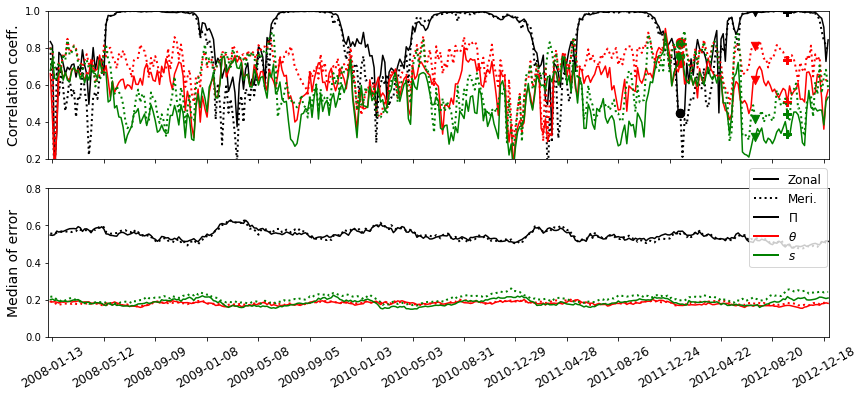

In [51]:
custom_lines = [Line2D([0], [0], color='k', lw=2, ls='-'),
                Line2D([0], [0], color='k', lw=2, ls=':'),
                Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='g', lw=2)]
ssize = 70
Nt = len(dsr.time)
Nt1 = -70
Nt2 = -35
Nt3 = -20
print(timeaxis[Nt1],timeaxis[Nt2],timeaxis[Nt3])


fig, (ax1,ax2) = plt.subplots(figsize=(14,6), nrows=2, ncols=1)
# fig.set_tight_layout(True)

ax1.plot(timeaxis[:Nt], dsr.rxP.isel(sig=1), 'k', label=r"$\Pi$ (zonal)")
ax1.plot(timeaxis[:Nt], dsr.ryP.isel(sig=1), 'k:', lw=2, label=r"$\Pi$ (meri)")
ax1.plot(timeaxis[:Nt], dsr.rxT.isel(sig=1), 'r', label=r"$\theta$ (zonal)")
ax1.plot(timeaxis[:Nt], dsr.ryT.isel(sig=1), 'r:', lw=2, label=r"$\theta$ (meri)")
ax1.plot(timeaxis[:Nt], dsr.rxS.isel(sig=1), 'g', label=r"$s$ (zonal)")
ax1.plot(timeaxis[:Nt], dsr.ryS.isel(sig=1), 'g:', lw=2, label=r"$s$ (meri)")
ax1.scatter(timeaxis[Nt1], dsr.rxP.isel(sig=1,time=Nt1), marker='o', c='k', s=ssize)
ax1.scatter(timeaxis[Nt1], dsr.ryP.isel(sig=1,time=Nt1), marker='o', c='k', s=ssize)
ax1.scatter(timeaxis[Nt1], dsr.rxT.isel(sig=1,time=Nt1), marker='o', c='r', s=ssize)
ax1.scatter(timeaxis[Nt1], dsr.ryT.isel(sig=1,time=Nt1), marker='o', c='r', s=ssize)
ax1.scatter(timeaxis[Nt1], dsr.rxS.isel(sig=1,time=Nt1), marker='o', c='g', s=ssize)
ax1.scatter(timeaxis[Nt1], dsr.ryS.isel(sig=1,time=Nt1), marker='o', c='g', s=ssize)
ax1.scatter(timeaxis[Nt2], dsr.rxP.isel(sig=1,time=Nt2), marker='v', c='k', s=ssize)
ax1.scatter(timeaxis[Nt2], dsr.ryP.isel(sig=1,time=Nt2), marker='v', c='k', s=ssize)
ax1.scatter(timeaxis[Nt2], dsr.rxT.isel(sig=1,time=Nt2), marker='v', c='r', s=ssize)
ax1.scatter(timeaxis[Nt2], dsr.ryT.isel(sig=1,time=Nt2), marker='v', c='r', s=ssize)
ax1.scatter(timeaxis[Nt2], dsr.rxS.isel(sig=1,time=Nt2), marker='v', c='g', s=ssize)
ax1.scatter(timeaxis[Nt2], dsr.ryS.isel(sig=1,time=Nt2), marker='v', c='g', s=ssize)
ax1.scatter(timeaxis[Nt3], dsr.rxP.isel(sig=1,time=Nt3), marker='P', c='k', s=ssize)
ax1.scatter(timeaxis[Nt3], dsr.ryP.isel(sig=1,time=Nt3), marker='P', c='k', s=ssize)
ax1.scatter(timeaxis[Nt3], dsr.rxT.isel(sig=1,time=Nt3), marker='P', c='r', s=ssize)
ax1.scatter(timeaxis[Nt3], dsr.ryT.isel(sig=1,time=Nt3), marker='P', c='r', s=ssize)
ax1.scatter(timeaxis[Nt3], dsr.rxS.isel(sig=1,time=Nt3), marker='P', c='g', s=ssize)
ax1.scatter(timeaxis[Nt3], dsr.ryS.isel(sig=1,time=Nt3), marker='P', c='g', s=ssize)


ax2.plot(timeaxis[:Nt], np.nanmedian(dse.exP.isel(sig=1),axis=(1,2)), 
         'k', label=r"$r^u_\Pi$")
ax2.plot(timeaxis[:Nt], np.nanmedian(dse.eyP.isel(sig=1),axis=(1,2)), 
         'k:', lw=2, label=r"$r^v_\Pi$")
ax2.plot(timeaxis[:Nt], np.nanmedian(dse.exT.isel(sig=1),axis=(1,2)), 
         'r', label=r"$r^u_\theta$")
ax2.plot(timeaxis[:Nt], np.nanmedian(dse.eyT.isel(sig=1),axis=(1,2)), 
         'r:', lw=2, label=r"$r^v_\theta$")
ax2.plot(timeaxis[:Nt], np.nanmedian(dse.exS.isel(sig=1),axis=(1,2)), 
         'g', label=r"$r^u_s$")
ax2.plot(timeaxis[:Nt], np.nanmedian(dse.eyS.isel(sig=1),axis=(1,2)), 
         'g:', lw=2, label=r"$r^v_s$")


ax2.legend(custom_lines, ['Zonal', 'Meri.', r"$\Pi$", r"$\theta$", r"$s$"], 
           bbox_to_anchor=(.89,.43), fontsize=12)

ax1.set_xlim(['2008-01-03','2012-12-31'])
ax2.set_xlim(['2008-01-03','2012-12-31'])
ax1.set_xticks(timeaxis[1::24])
ax1.set_xticklabels([])
ax2.set_xticks(timeaxis[1::24])
ax2.set_xticklabels(timeaxis[1::24], rotation=30, fontsize=12)
ax1.set_ylim([.2,1.])
ax2.set_ylim([0.,.8])
ax1.set_ylabel(r"Correlation coeff.", fontsize=14)
ax2.set_ylabel(r"Median of error", fontsize=14)
plt.savefig(op.join(ddir,'Figures/CorrCoef-error_5Dave_isig25.pdf'))

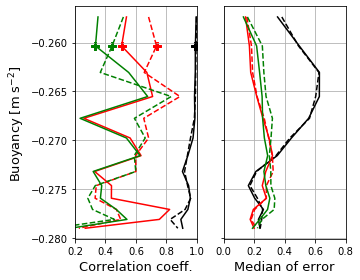

In [60]:
buoyb = -grav*dsr.rxP.sig*rhoConst**-1
ssize = 70
ntime = Nt3
if ntime == Nt1:
    mark = 'o'
elif ntime == Nt2:
    mark = 'v'
else:
    mark = 'P'
fig, (ax1,ax2) = plt.subplots(figsize=(5,4), nrows=1, ncols=2)
fig.set_tight_layout(True)

ax1.plot(dsr.rxP.isel(time=ntime), buoyb, 'k', label=r"$\Pi$ (zonal)")
ax1.plot(dsr.ryP.isel(time=ntime), buoyb, 'k--', label=r"$\Pi$ (meri)")
ax1.plot(dsr.rxT.isel(time=ntime), buoyb, 'r', label=r"$\theta$ (zonal)")
ax1.plot(dsr.ryT.isel(time=ntime), buoyb, 'r--', label=r"$\theta$ (meri)")
ax1.plot(dsr.rxS.isel(time=ntime), buoyb, 'g', label=r"$s$ (zonal)")
ax1.plot(dsr.ryS.isel(time=ntime), buoyb, 'g--', label=r"$s$ (meri)")

ax1.scatter(dsr.rxP.isel(time=ntime,sig=1), buoyb.isel(sig=1), 
            marker=mark, c='k', s=ssize)
ax1.scatter(dsr.ryP.isel(time=ntime,sig=1), buoyb.isel(sig=1), 
            marker=mark, c='k', s=ssize)
ax1.scatter(dsr.rxT.isel(time=ntime,sig=1), buoyb.isel(sig=1), 
            marker=mark, c='r', s=ssize)
ax1.scatter(dsr.ryT.isel(time=ntime,sig=1), buoyb.isel(sig=1), 
            marker=mark, c='r', s=ssize)
ax1.scatter(dsr.rxS.isel(time=ntime,sig=1), buoyb.isel(sig=1), 
            marker=mark, c='g', s=ssize)
ax1.scatter(dsr.ryS.isel(time=ntime,sig=1), buoyb.isel(sig=1), 
            marker=mark, c='g', s=ssize)

ax2.plot(np.nanmedian(dse.exP.isel(time=ntime),axis=(0,1)), buoyb, 
         'k', label=r"$r^u_\Pi$")
ax2.plot(np.nanmedian(dse.eyP.isel(time=ntime),axis=(0,1)), buoyb, 
         'k--', label=r"$r^v_\Pi$")
ax2.plot(np.nanmedian(dse.exT.isel(time=ntime),axis=(0,1)), buoyb, 
         'r', label=r"$r^u_\theta$")
ax2.plot(np.nanmedian(dse.eyT.isel(time=ntime),axis=(0,1)), buoyb, 
         'r--', label=r"$r^v_\theta$")
ax2.plot(np.nanmedian(dse.exS.isel(time=ntime),axis=(0,1)), buoyb, 
         'g', label=r"$r^u_s$")
ax2.plot(np.nanmedian(dse.eyS.isel(time=ntime),axis=(0,1)), buoyb, 
         'g--', label=r"$r^v_s$")

# ax1.legend(fontsize=12, loc='lower left')
ax1.set_xlim([.2,1.])
ax2.set_xlim([0.,.8])
# ax1.set_yticks([-.36,-.34,-.32,-.30,-.28,-.26])
# ax2.set_yticks([-.36,-.34,-.32,-.30,-.28,-.26])
ax2.set_yticklabels([])
ax1.set_xlabel(r"Correlation coeff.", fontsize=13)
ax2.set_xlabel(r"Median of error", fontsize=13)
ax1.set_ylabel(r"Buoyancy [m s$^{-2}$]", fontsize=13)

ax1.grid(True)
ax2.grid(True)

plt.savefig(op.join(ddir,'Figures/CorrCoef-error_5Dave_%10s.pdf' 
                    % str(timeaxis[ntime]))
           )

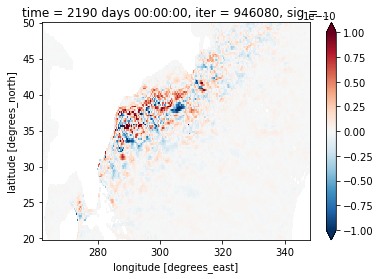

In [30]:
upPp.isel(sig=3).plot(vmax=1e-10)

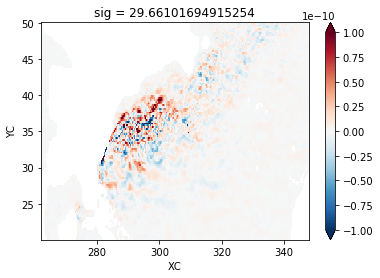

In [16]:
FxP.isel(sig=3).plot(vmax=1e-10)

In [10]:
timeaxis

array(['1964-01-01', '1964-01-06', '1964-01-11', '1964-01-16',
       '1964-01-21', '1964-01-26', '1964-01-31', '1964-02-05',
       '1964-02-10', '1964-02-15', '1964-02-20', '1964-02-25',
       '1964-03-01', '1964-03-06', '1964-03-11', '1964-03-16',
       '1964-03-21', '1964-03-26', '1964-03-31', '1964-04-05',
       '1964-04-10', '1964-04-15', '1964-04-20', '1964-04-25',
       '1964-04-30', '1964-05-05', '1964-05-10', '1964-05-15',
       '1964-05-20', '1964-05-25', '1964-05-30', '1964-06-04',
       '1964-06-09', '1964-06-14', '1964-06-19', '1964-06-24',
       '1964-06-29', '1964-07-04', '1964-07-09', '1964-07-14',
       '1964-07-19', '1964-07-24', '1964-07-29', '1964-08-03',
       '1964-08-08', '1964-08-13', '1964-08-18', '1964-08-23',
       '1964-08-28', '1964-09-02', '1964-09-07', '1964-09-12',
       '1964-09-17', '1964-09-22', '1964-09-27', '1964-10-02',
       '1964-10-07', '1964-10-12', '1964-10-17', '1964-10-22',
       '1964-10-27', '1964-11-01', '1964-11-06', '1964-

In [20]:
timeaxis[146]

numpy.datetime64('1966-01-01')